NonExistentTimeError: 2024-03-31 02:00:00

                        U12
WsDateTime                 
2024-12-31 23:00:00  416.79
2024-12-31 23:00:05  416.61
2024-12-31 23:00:10  416.84
2024-12-31 23:00:15  416.79
2024-12-31 23:00:20  416.64


C:\Users\rs1044\AppData\Local\Temp\ipykernel_5444\3005584857.py:8: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  win = df.last("60min")


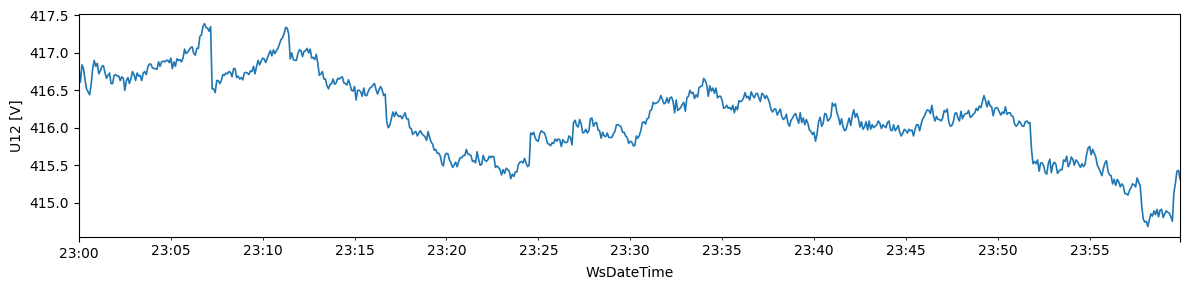

In [10]:
import pandas as pd, matplotlib.pyplot as plt

# read + index
df = pd.read_csv("dataset_clean/EPI_ChipPress/U12/2024_U12.csv.xz",
                 usecols=["WsDateTime","U12"], parse_dates=["WsDateTime"]).set_index("WsDateTime").sort_index()

# pick a 5-minute window (last 5 minutes in file). Or use: df.loc["2024-06-01 12:00":"2024-06-01 12:05"]
win = df.last("60min")

print(win.head())  # peek at the high-res rows
win.U12.plot(figsize=(12,3), linewidth=1.2); plt.ylabel("U12 [V]"); plt.tight_layout(); plt.show()


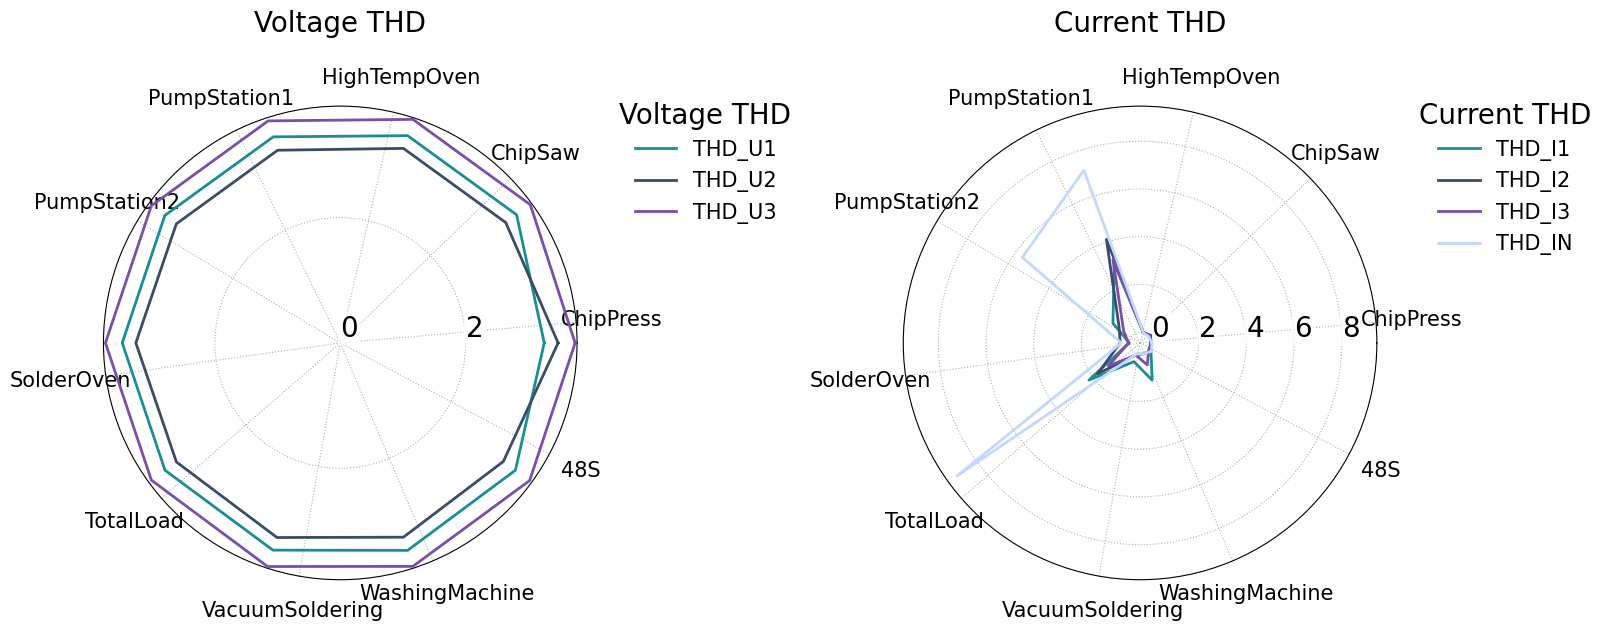

In [24]:
from pathlib import Path
import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NEW: your palette
#PALETTE = ["#1B8A8F", "#3b4c68", "#7A4EAB", "#a0b5e2", "#D55E00", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]
PALETTE = ["#1A8E95", "#3B4C68", "#7A4EAB", "#1A8E95", "#3B4C68", "#7A4EAB", "#c3d8ff", "#BFC6CF"]

THD_VOLTAGE_CANDIDATES = ["THD_U1","THD_U2","THD_U3"]
THD_CURRENT_CANDIDATES = ["THD_I1","THD_I2","THD_I3","THD_IN"]

def _machine_dirs(base: Path):
    return sorted([p for p in base.iterdir() if p.is_dir()], key=lambda p: p.name)

def _find_years(machine_dir: Path, meas: str):
    stats_dir = machine_dir / meas
    if not stats_dir.exists():
        return []
    years = []
    for f in stats_dir.glob(f"*_{meas}_stats.csv"):
        m = re.match(r"^(\d{4})_", f.stem)
        if m:
            years.append(int(m.group(1)))
    return sorted(years)

def _stats_path(machine_dir: Path, meas: str, year_rule):
    years = _find_years(machine_dir, meas)
    if not years:
        return None
    y = years[-1] if year_rule == "latest" else int(year_rule)
    if y not in years:
        return None
    p = machine_dir / meas / f"{y}_{meas}_stats.csv"
    return p if p.exists() else None

def _read_stats_row(path: Path) -> pd.Series | None:
    try:
        df = pd.read_csv(path)
        if df.empty:
            return None
        row = df.iloc[0].copy()
        row.index = [c.strip().lower() for c in row.index]
        return row
    except Exception:
        return None

def _get_stat_value(path: Path, stat: str) -> float:
    row = _read_stats_row(path)
    if row is None:
        return np.nan
    try:
        return float(row[stat.lower()])
    except Exception:
        return np.nan

def _downsample_labels(labels: list[str], every: int | None) -> list[str]:
    if every is None:
        every = max(1, math.ceil(len(labels) / 12))
    return [lbl if (i % every == 0) else "" for i, lbl in enumerate(labels)]

def plot_thd_radars_topN(
    base_dir: str | Path,
    year: str | int = "latest",
    stat: str = "q95",
    exclude_machines: tuple[str, ...] = ("EPI_PV",),
    max_machines: int = 10,
    label_every: int | None = None,
    figsize=(14, 7),
    save: str | None = None,
    strip_prefixes: tuple[str, ...] = ("EPI_", "TEC_"),
    # --- NEW: label positioning controls (B: stagger only labels) ---
    tick_angle_offset_deg: float = 0.0,  # global rotation for both panels (labels only)
    stagger_labels: bool = True,         # enable staggering
    stagger_deg: float = 2.0,            # additional angle for every 2nd label
    xtick_pad: int = 8,                  # label padding from axes
):
    base_dir = Path(base_dir)

    machines_all = [mdir.name for mdir in _machine_dirs(base_dir) if mdir.name not in exclude_machines]
    if not machines_all:
        raise RuntimeError("No machines found after applying exclusions.")

    presence_score = {}
    volt_values = {}
    curr_values = {}

    for m in machines_all:
        mdir = base_dir / m
        v_count = 0
        for cand in THD_VOLTAGE_CANDIDATES:
            p = _stats_path(mdir, cand, year)
            if p is not None:
                v_count += 1
        i_count = 0
        for cand in THD_CURRENT_CANDIDATES:
            p = _stats_path(mdir, cand, year)
            if p is not None:
                i_count += 1
        presence_score[m] = (v_count + i_count, v_count, i_count)

    machines_sorted = sorted(
        machines_all, key=lambda m: (-presence_score[m][0], -presence_score[m][1], -presence_score[m][2], m)
    )
    machines = machines_sorted[:max_machines]
    if not machines:
        raise RuntimeError("No machines had any THD files.")

    for lab in THD_VOLTAGE_CANDIDATES:
        vals = []
        for m in machines:
            p = _stats_path(base_dir / m, lab, year)
            vals.append(_get_stat_value(p, stat) if p is not None else np.nan)
        if np.isfinite(np.asarray(vals, float)).any():
            volt_values[lab] = np.asarray(vals, float)

    for lab in THD_CURRENT_CANDIDATES:
        vals = []
        for m in machines:
            p = _stats_path(base_dir / m, lab, year)
            vals.append(_get_stat_value(p, stat) if p is not None else np.nan)
        if np.isfinite(np.asarray(vals, float)).any():
            curr_values[lab] = np.asarray(vals, float)

    # Stable color map per THD channel
    all_labels = THD_VOLTAGE_CANDIDATES + THD_CURRENT_CANDIDATES
    color_map = {lab: PALETTE[i % len(PALETTE)] for i, lab in enumerate(all_labels)}

    # ---------- plotting ----------
    fig, axes = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=figsize, constrained_layout=True)
    fig.set_constrained_layout_pads(wspace=0.0, hspace=0.02, w_pad=0.05, h_pad=0.05)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    strip_re = re.compile(rf"^({'|'.join(map(re.escape, strip_prefixes))})")
    display_names = [strip_re.sub("", m) for m in machines]

    def plot_panel(ax, data_dict: dict, title: str):
        N = len(machines)
        # Base angles for the data (do NOT stagger these to keep spokes aligned)
        angles = np.linspace(0, 2*np.pi, N, endpoint=False)
        # Label angles: global rotation + optional staggering
        angles_lbl = angles + np.deg2rad(tick_angle_offset_deg)
        if stagger_labels and N > 6:
            # Stagger every second *visible* label slightly
            angles_lbl[1::2] += np.deg2rad(stagger_deg)

        # Labels (with possible downsampling)
        labels = _downsample_labels(display_names, label_every)
        ax.set_xticks(angles_lbl, labels, fontsize=15)
        ax.tick_params(axis='x', pad=xtick_pad)
        ax.set_rlabel_position(0)
        ax.grid(True, linestyle=":", zorder=5)

        # Y limits from data
        all_vals = np.concatenate([v for v in data_dict.values()]) if data_dict else np.array([])
        finite = all_vals[np.isfinite(all_vals)] if all_vals.size else np.array([])
        if finite.size == 0:
            vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = float(np.nanmin(finite)), float(np.nanmax(finite))
            if vmin == vmax:
                vmin, vmax = 0.0, (vmax if vmax != 0 else 1.0)
        span = vmax - vmin
        ax.set_ylim(vmin - 0.05 * span, vmax + 0.05 * span)

        lo, hi = ax.get_ylim()
        lo_i, hi_i = 0, int(np.floor(hi))
        if hi_i <= lo_i:
            hi_i = lo_i + 1
        step = 2
        ticks = np.arange(lo_i, hi_i + 1, step)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{int(t)}" for t in ticks])

        for lbl in ax.get_yticklabels():
            lbl.set_fontsize(20)
            lbl.set_bbox(dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.5))

        # Plot data using the UN-staggered base angles so traces align with spokes
        ang_c = np.r_[angles, angles[0]]
        for lab, vals in data_dict.items():
            vals = np.asarray(vals, float)
            vals_c = np.r_[vals, vals[0]]
            ax.plot(ang_c, vals_c, linewidth=2, zorder=3, color=color_map.get(lab, "#000000"), label=lab)

        if data_dict:
            leg = ax.legend(
                loc="upper left", bbox_to_anchor=(1.05, 1.05),
                fontsize=15, frameon=False, title=f"{title}"
            )
            leg.get_title().set_fontsize(20)
        ax.set_title(f"{title}", pad=26, fontsize=20)

    plot_panel(axes[0], volt_values, "Voltage THD")
    plot_panel(axes[1], curr_values, "Current THD")

    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

    return {
        "machines": machines,
        "display_names": display_names,
        "stat": stat,
        "voltage_labels": list(volt_values.keys()),
        "current_labels": list(curr_values.keys()),
    }


# ===== Example execution =====
details = plot_thd_radars_topN(
    base_dir="dataset_clean_validation",
    year="latest",
    stat="mean",
    max_machines=10,
    figsize=(16, 12),
    save="01Figures/Fig9_thd_radar.pdf",
    tick_angle_offset_deg=5.0,
    stagger_labels=True,
    stagger_deg=3.0,
    xtick_pad=15,
)


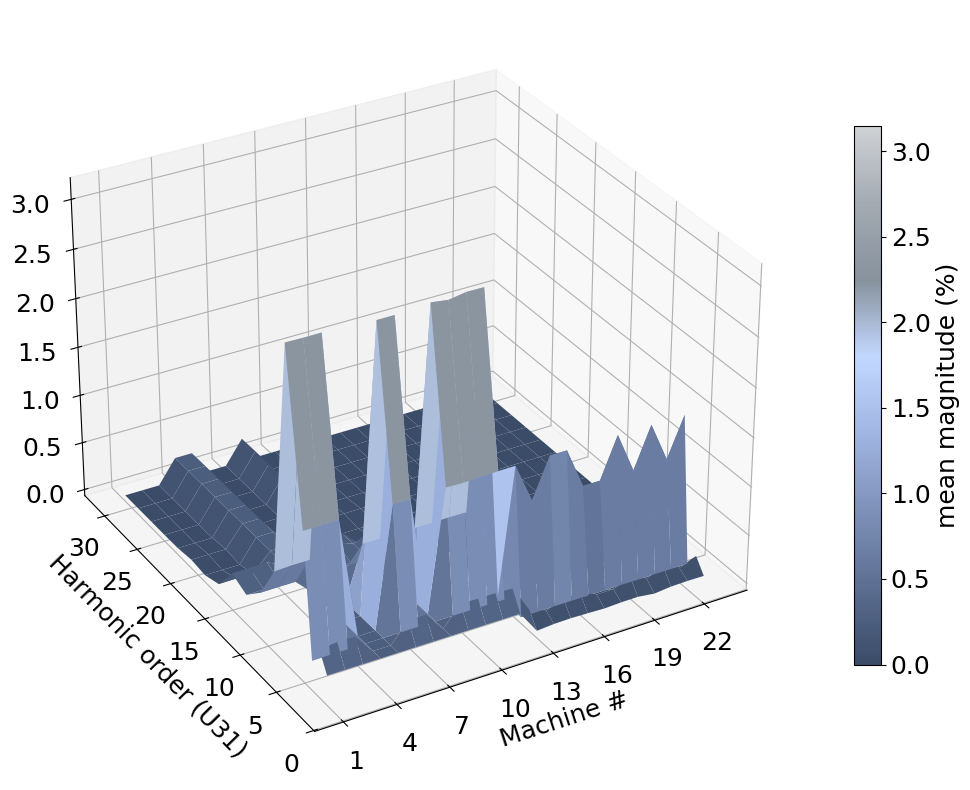

In [126]:
from __future__ import annotations
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.lines import Line2D

def plot_harmonics_fleet(
    base_dir: str | Path,
    year: str | int = "latest",
    stat: str = "mean",
    fallbacks: tuple[str, ...] = ("q75","q50"),
    agg: str = "mean",
    plot_kind: str = "heatmap",             # "heatmap" | "surface"
    harm_sel: str | None = None,            # e.g., "U12","I1","IN", ...
    odd_only: bool = True,
    order_range: tuple[int | None, int | None] = (3, 31),
    exclude_machines: tuple[str, ...] = (),
    color_clip_quantiles: tuple[float, float] = (1, 99),
    log_color: bool = False,
    figsize: tuple[float, float] | None = None,
    save: str | None = None,
) -> dict:

    base_dir = Path(base_dir)

    # palette -> smooth sequential cmap
    palette = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]
    cmap = LinearSegmentedColormap.from_list("fleet_seq", palette, N=256)

    # ---------- helpers ----------
    def list_machines(base: Path) -> list[str]:
        ms = [p.name for p in base.iterdir() if p.is_dir()]
        ms = [m for m in ms if m not in exclude_machines]
        return sorted(ms)

    def find_latest_year(stats_dir: Path, meas: str) -> str | None:
        years = []
        for f in stats_dir.glob(f"*_{meas}_stats.csv"):
            m = re.match(r"^(\d{4})_", f.stem)
            if m: years.append(int(m.group(1)))
        return str(max(years)) if years else None

    def stats_path_for(meas_dir: Path, year_sel, meas: str) -> Path | None:
        if year_sel == "latest":
            y = find_latest_year(meas_dir, meas)
            if y is None: return None
            p = meas_dir / f"{y}_{meas}_stats.csv"
            return p if p.exists() else None
        p = meas_dir / f"{year_sel}_{meas}_stats.csv"
        return p if p.exists() else None

    def read_stat(path: Path, stat_name: str, fb: tuple[str, ...]) -> float | None:
        try:
            df = pd.read_csv(path, nrows=1)
            if df.empty: return None
            cols = {c.strip().lower(): c for c in df.columns}
            for key in (stat_name.lower(), *[s.lower() for s in fb]):
                if key in cols:
                    v = pd.to_numeric(df.loc[0, cols[key]], errors="coerce")
                    if pd.notna(v): return float(v)
            return None
        except Exception:
            return None

    # which harmonics (family) to include
    def build_matcher(hsel: str | None):
        if hsel is None:
            pats = (
                r"^(I[123N]_h)(\d+)$",
                r"^(U(?:12|23|31|[123])_h)(\d+)$",
                r"^(V1_h)(\d+)$",
            )
            regexes = [re.compile(p) for p in pats]
            def matcher(meas_name: str):
                for rg in regexes:
                    m = rg.match(meas_name)
                    if m: return m.group(1), int(m.group(2))
                return None
            return matcher
        rg = re.compile(rf"^({re.escape(hsel)}_h)(\d+)$")
        def matcher(meas_name: str):
            m = rg.match(meas_name)
            return (m.group(1), int(m.group(2))) if m else None
        return matcher

    match_harmonic = build_matcher(harm_sel)

    def keep_order(n: int) -> bool:
        omin, omax = order_range
        if odd_only and n % 2 == 0: return False
        if omin is not None and n < omin: return False
        if omax is not None and n > omax: return False
        return True

    # ---------- build matrix ----------
    machines = list_machines(base_dir)
    order_set, per_machine = set(), {}

    for m in machines:
        od = {}
        for meas_dir in (base_dir / m).iterdir():
            if not meas_dir.is_dir(): continue
            meas = meas_dir.name
            mh = match_harmonic(meas)
            if not mh: continue
            _, n = mh
            if not keep_order(n): continue
            sp = stats_path_for(meas_dir, year, meas)
            if sp is None: continue
            v = read_stat(sp, stat, fallbacks)
            if v is None or np.isnan(v): continue
            od.setdefault(n, []).append(v)
            order_set.add(n)
        per_machine[m] = od

    orders = sorted(order_set)
    M = np.full((len(orders), len(machines)), np.nan, float)

    for j, m in enumerate(machines):
        mvals = per_machine.get(m, {})
        for i, n in enumerate(orders):
            # TEC rule: orders > 5 => zero
            if m.startswith("TEC_") and n > 5:
                M[i, j] = 0.0
                continue
            vals = mvals.get(n, [])
            if not vals: continue
            if   agg == "max":    M[i, j] = np.nanmax(vals)
            elif agg == "mean":   M[i, j] = np.nanmean(vals)
            elif agg == "median": M[i, j] = np.nanmedian(vals)
            else:                 M[i, j] = np.nanmax(vals)

    # ---------- plotting ----------
    finite = M[np.isfinite(M)]
    if finite.size:
        vmin = np.percentile(finite, color_clip_quantiles[0])
        vmax = np.percentile(finite, color_clip_quantiles[1])
        if vmin == vmax: vmax = vmin + 1e-6
    else:
        vmin, vmax = 0, 1

    fam = harm_sel if harm_sel else "all"

    if plot_kind.lower() == "surface":
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        x_idx = np.arange(len(machines))
        X, Y = np.meshgrid(x_idx, np.array(orders))
        Z = np.where(np.isfinite(M), M, np.nanmean(finite) if finite.size else 0.0)

        if figsize is None: figsize = (18, 10)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection="3d")

 
        # Larger fonts
        ax.tick_params(axis="both", which="major", labelsize=18)

        surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, cmap=cmap, vmin=vmin, vmax=vmax)

        # Colorbar
        mappable = plt.cm.ScalarMappable(cmap=cmap)
        mappable.set_array(Z)
        cbar = fig.colorbar(mappable, ax=ax, shrink=0.7)
        cbar.ax.tick_params(labelsize=18)
        cbar.set_label(f"{stat} magnitude (%)", fontsize=18)

        # X ticks as numbers, thinned to avoid overlap
        max_labels = 8
        step = max(1, int(np.ceil(len(machines) / max_labels)))
        tick_positions = x_idx[::step]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([str(i+1) for i in tick_positions], fontsize=18)
        ax.set_xlabel("Machine #", fontsize=18, labelpad=10)

        ax.tick_params(axis="x", labelsize=18, pad=6)
        ax.tick_params(axis="y", labelsize=18, pad=6)
        ax.tick_params(axis="z", labelsize=18, pad=10)

        ax.set_ylabel(f"Harmonic order ({fam})", fontsize=18, labelpad=10)
        ax.view_init(elev=30, azim=-120)

        if save: plt.savefig(save, bbox_inches="tight")
        plt.show()

    else:
        if figsize is None:
            figsize = (max(12, 0.6 * len(machines)), 8)
        fig, ax = plt.subplots(figsize=figsize)
        norm = LogNorm(vmin=max(vmin, 1e-9), vmax=max(vmax, 1e-9)) if log_color else None
        M_plot = np.array(M, copy=True)
        M_plot = np.ma.masked_where(~np.isfinite(M_plot) | ((M_plot <= 0) if log_color else False), M_plot)
        im = ax.imshow(M_plot, aspect="auto", origin="lower",
                       vmin=None if log_color else vmin,
                       vmax=None if log_color else vmax,
                       norm=norm, cmap=cmap)

        ax.set_yticks(np.arange(len(orders))); ax.set_yticklabels(orders, fontsize=11)
        ax.set_xticks(np.arange(len(machines))); ax.set_xticklabels(machines, rotation=90, fontsize=10)
        
        ax.set_xlabel("Machine", labelpad=16, fontsize=12)
        ax.set_ylabel(f"Harmonic order ({fam})", fontsize=12)

        cbar = plt.colorbar(im, ax=ax, pad=0.01)
        lab = f"{stat} magnitude (%)"
        if fallbacks: lab += f" (fallbacks: {', '.join(fallbacks)})"
        cbar.set_label(lab); cbar.ax.tick_params(labelsize=11)

        if save: plt.savefig(save, bbox_inches="tight")
        plt.show()

    return {"machines": machines, "orders": orders, "M": M}

# Heatmap for current I1, odd orders 3..31
# Voltage line-to-line U12 as 3D surface, include all orders 1..31
result = plot_harmonics_fleet(
    base_dir="dataset_clean_validation",
    plot_kind="surface",
    harm_sel="U31",
    odd_only=False,
    order_range=(1, 31),
    save="01Figures/U31_harmonics_Surfaceplot.pdf"
)


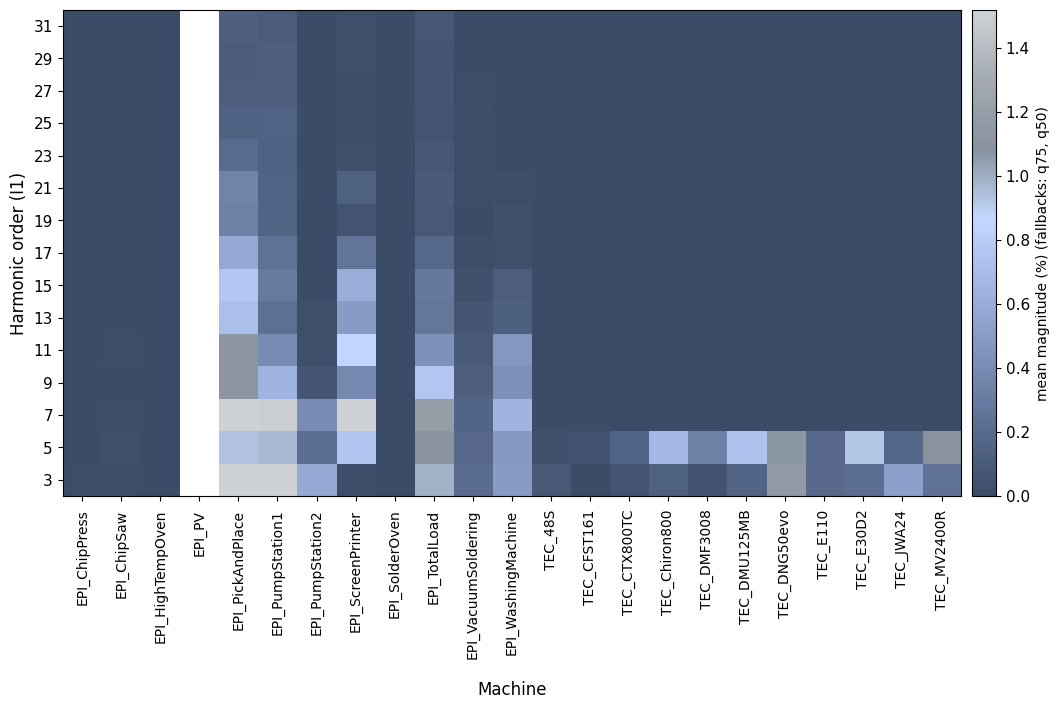

In [39]:
result = plot_harmonics_fleet(
    base_dir="dataset_clean_validation",
    year="latest",
    stat="mean",
    agg="mean",
    plot_kind="heatmap",
    harm_sel="I1",
    odd_only=True,
    order_range=(3, 31),
    save="Fig_Harmonics_I1.pdf",
)

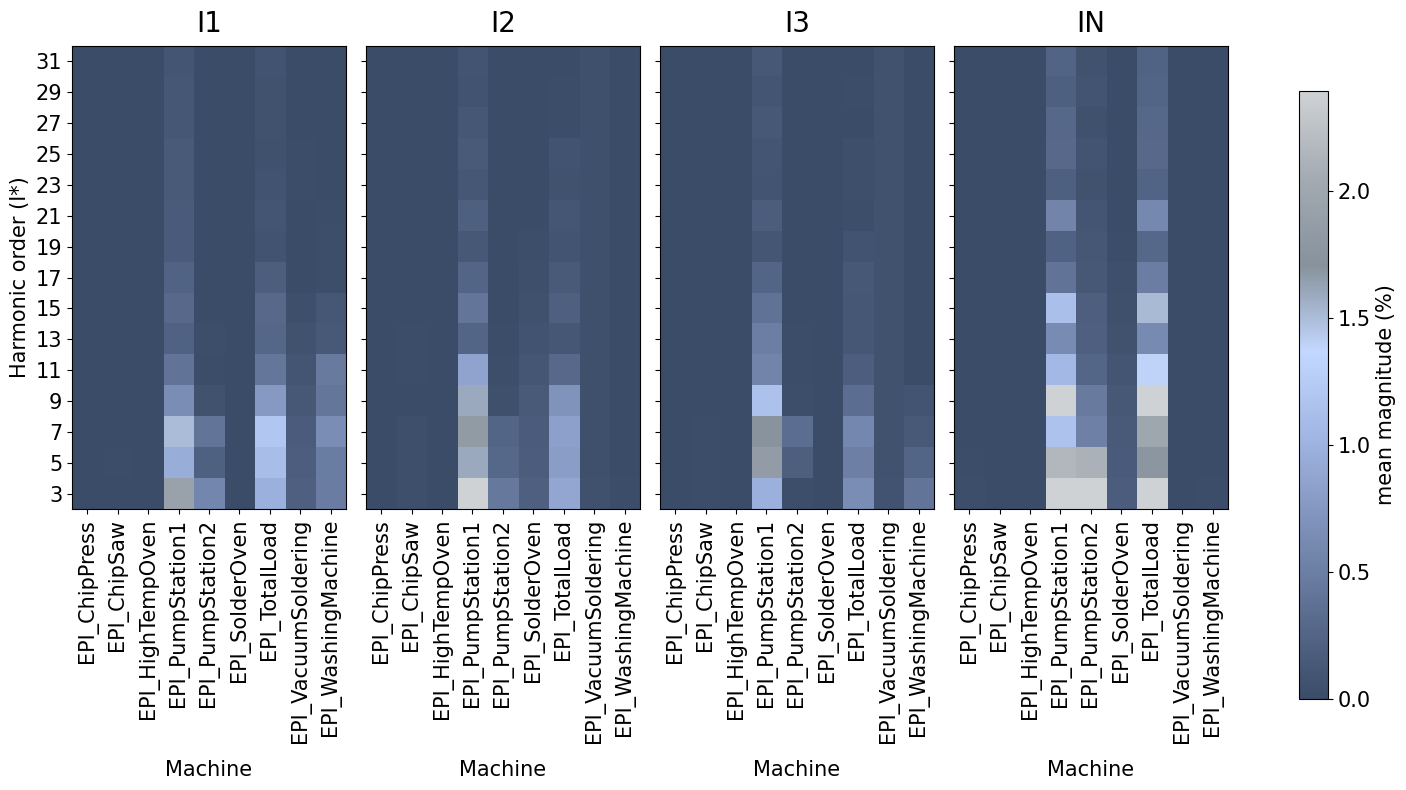

In [150]:
def plot_currents_harmonics_grid(
    base_dir: str | Path,
    year: str | int = "latest",
    stat: str = "mean",
    fallbacks: tuple[str, ...] = ("q75", "q50"),
    agg: str = "mean",
    order_range: tuple[int | None, int | None] = (2, 31),
    exclude_machines: tuple[str, ...] = ("EPI_PV",),
    color_clip_quantiles: tuple[float, float] = (1, 99),
    log_color: bool = False,
    figsize: tuple[float, float] | None = None,
    save: str | None = None,
) -> dict:
    """
    Build one figure with 4 heatmaps (I1, I2, I3, IN) for harmonic orders 2..31,
    excluding 'EPI_PV'. Uses the same data logic and palette style as plot_harmonics_fleet.
    Returns dict with machines, orders, and data per family.
    """
    base_dir = Path(base_dir)

    # --- palette / cmap (same style as your original) ---
    palette = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]
    cmap = LinearSegmentedColormap.from_list("fleet_seq", palette, N=256)

    # ---------- helpers (mirror the originals where needed) ----------
    def list_machines(base: Path) -> list[str]:
        ms = [p.name for p in base.iterdir() if p.is_dir()]
        ms = [m for m in ms if m not in exclude_machines]
        return sorted(ms)

    def find_latest_year(stats_dir: Path, meas: str) -> str | None:
        years = []
        for f in stats_dir.glob(f"*_{meas}_stats.csv"):
            m = re.match(r"^(\d{4})_", f.stem)
            if m:
                years.append(int(m.group(1)))
        return str(max(years)) if years else None

    def stats_path_for(meas_dir: Path, year_sel, meas: str) -> Path | None:
        if year_sel == "latest":
            y = find_latest_year(meas_dir, meas)
            if y is None:
                return None
            p = meas_dir / f"{y}_{meas}_stats.csv"
            return p if p.exists() else None
        p = meas_dir / f"{year_sel}_{meas}_stats.csv"
        return p if p.exists() else None

    def read_stat(path: Path, stat_name: str, fb: tuple[str, ...]) -> float | None:
        try:
            df = pd.read_csv(path, nrows=1)
            if df.empty:
                return None
            cols = {c.strip().lower(): c for c in df.columns}
            for key in (stat_name.lower(), *[s.lower() for s in fb]):
                if key in cols:
                    v = pd.to_numeric(df.loc[0, cols[key]], errors="coerce")
                    if pd.notna(v):
                        return float(v)
            return None
        except Exception:
            return None

    def keep_order(n: int) -> bool:
        omin, omax = order_range
        if omin is not None and n < omin:
            return False
        if omax is not None and n > omax:
            return False
        return True

    # Build once to keep machine order consistent across families
    machines = list_machines(base_dir)

    # Families to plot left->right
    families = ["I1", "I2", "I3", "IN"]

    # Pre-collect orders and matrices for each family
    data = {}
    all_finite_vals = []

    # Determine the union of orders across all families (restricted to keep_order)
    # We also pre-scan to know which orders actually exist.
    union_orders = set()
    per_family_temp = {}

    for fam in families:
        order_set, per_machine = set(), {}
        fam_regex = re.compile(rf"^({re.escape(fam)}_h)(\d+)$")

        for m in machines:
            od = {}
            m_dir = base_dir / m
            if not m_dir.exists():
                per_machine[m] = od
                continue

            for meas_dir in m_dir.iterdir():
                if not meas_dir.is_dir():
                    continue
                meas = meas_dir.name
                mm = fam_regex.match(meas)
                if not mm:
                    continue
                n = int(mm.group(2))
                if not keep_order(n):
                    continue
                sp = stats_path_for(meas_dir, year, meas)
                if sp is None:
                    continue
                v = read_stat(sp, stat, fallbacks)
                if v is None or np.isnan(v):
                    continue
                od.setdefault(n, []).append(v)
                order_set.add(n)
            per_machine[m] = od

        orders = sorted(order_set)
        union_orders.update(orders)
        per_family_temp[fam] = (orders, per_machine)

    orders = sorted([n for n in union_orders if keep_order(n)])  # final y-axis (2..31)

    # Build matrices aligned to the same orders and machine list
    for fam in families:
        fam_orders, per_machine = per_family_temp[fam]
        M = np.full((len(orders), len(machines)), np.nan, float)

        for j, m in enumerate(machines):
            mvals = per_machine.get(m, {})
            for i, n in enumerate(orders):
                vals = mvals.get(n, [])
                if not vals:
                    continue
                if   agg == "max":    M[i, j] = np.nanmax(vals)
                elif agg == "mean":   M[i, j] = np.nanmean(vals)
                elif agg == "median": M[i, j] = np.nanmedian(vals)
                else:                 M[i, j] = np.nanmax(vals)

        data[fam] = M
        finite = M[np.isfinite(M)]
        if finite.size:
            all_finite_vals.append(finite)

    # Global color scale across all four panels
    if all_finite_vals:
        finite_all = np.concatenate(all_finite_vals)
        vmin = np.percentile(finite_all, color_clip_quantiles[0])
        vmax = np.percentile(finite_all, color_clip_quantiles[1])
        if vmin == vmax:
            vmax = vmin + 1e-6
    else:
        vmin, vmax = 0, 1

    # --- plotting ---
        # --- plotting ---
    if figsize is None:
        figsize = (max(16, 0.35 * len(machines) * len(families)), 8)

    fig, axes = plt.subplots(1, 4, figsize=figsize, sharey=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    norm = LogNorm(vmin=max(vmin, 1e-9), vmax=max(vmax, 1e-9)) if log_color else None
    ims = []

    for ax, fam in zip(axes, families):
        M = data[fam]
        M_plot = np.array(M, copy=True)
        M_plot = np.ma.masked_where(~np.isfinite(M_plot) | ((M_plot <= 0) if log_color else False), M_plot)
        im = ax.imshow(
            M_plot,
            aspect="auto",
            origin="lower",
            vmin=None if log_color else vmin,
            vmax=None if log_color else vmax,
            norm=norm,
            cmap=cmap
        )
        ims.append(im)

        ax.set_title(fam, fontsize=20, pad=10)
        ax.set_xticks(np.arange(len(machines)))
        ax.set_xticklabels(machines, rotation=90, fontsize=15)
        ax.set_xlabel("Machine", labelpad=12, fontsize=15)

    axes[0].set_yticks(np.arange(len(orders)))
    axes[0].set_yticklabels(orders, fontsize=15)
    axes[0].set_ylabel("Harmonic order (I*)", fontsize=15)

    # --- more right spacing + move colorbar further right ---
    right_gutter = 0.22    # space to reserve on the right side of the figure
    cbar_width   = 0.018   # width of the colorbar axes
    cbar_y0, cbar_y1 = 0.12, 0.88  # vertical span (0..1 figure coords)
    cbar_x0 = 1 - right_gutter + 0.035  # push the colorbar a bit to the right inside the gutter

    # Pack subplots into the left area, leave a gutter on the right
    fig.tight_layout(rect=[0.0, 0.0, 1.0 - right_gutter, 1.0])

    # Create a dedicated colorbar axis in the right gutter
    cbar_ax = fig.add_axes([cbar_x0, cbar_y0, cbar_width, (cbar_y1 - cbar_y0)])
    cbar = fig.colorbar(ims[0], cax=cbar_ax)
    lab = f"{stat} magnitude (%)"
    cbar.set_label(lab, fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()


    return {"machines": machines, "orders": orders, "data": data, "vmin": vmin, "vmax": vmax}

# --- Example call (one figure, 4 panels, orders 2..31, exclude EPI_PV) ---
grid = plot_currents_harmonics_grid(
    base_dir="dataset_clean_validation",
    year="latest",
    stat="mean",
    #fallbacks=("q75","q50"),
    agg="mean",
    order_range=(2, 31),
    exclude_machines=("EPI_PV","TEC_E30D2", "EPI_PickAndPlace", "EPI_ScreenPrinter", "TEC_CFST161", "TEC_JWA24", "TEC_48S", "TEC_CTX800TC", "TEC_CTX800TC", "TEC_DNG50evo", "TEC_MV2400R", "TEC_Chiron800", "TEC_DMF3008", "TEC_DMU125MB", "TEC_E110"),
    log_color=False,
    save="01Figures/I123N_harmonics_heatmaps_2to31.pdf"
)

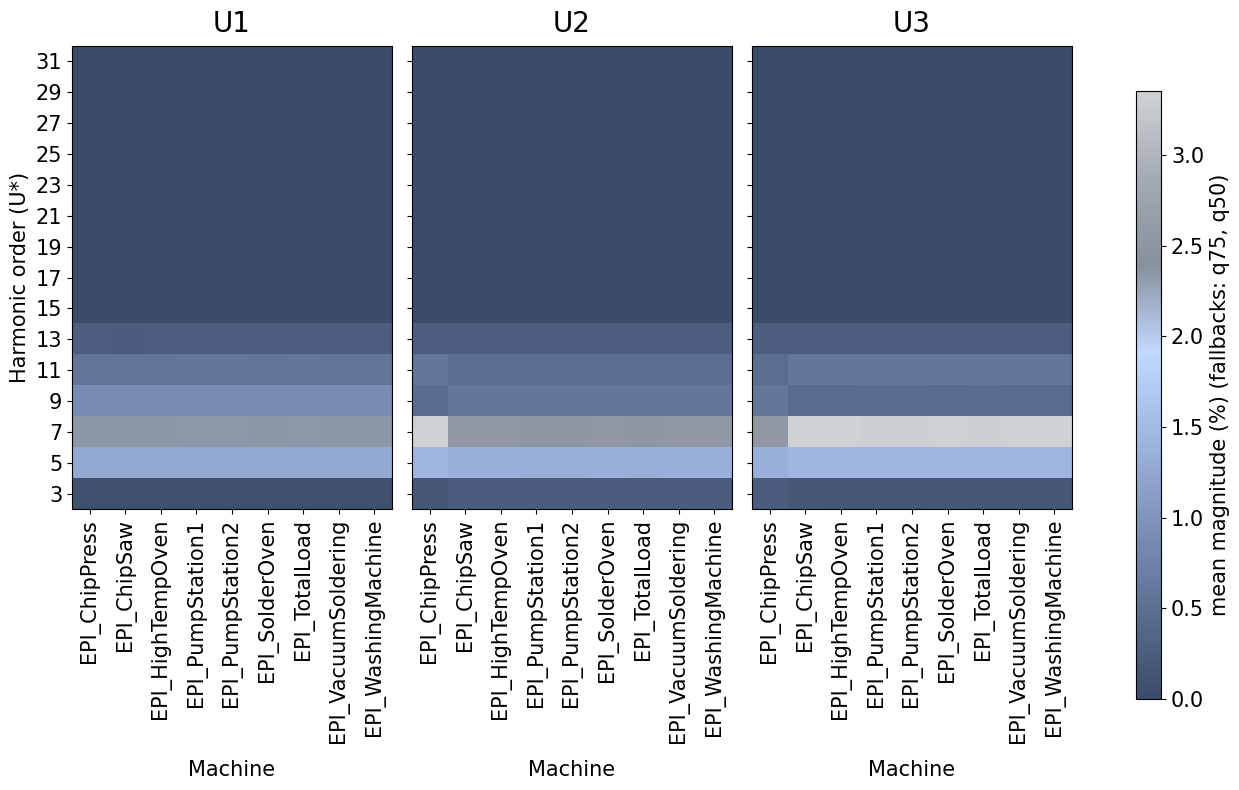

In [151]:
def plot_voltage_harmonics_grid(
    base_dir: str | Path,
    year: str | int = "latest",
    stat: str = "mean",
    fallbacks: tuple[str, ...] = ("q75", "q50"),
    agg: str = "mean",
    order_range: tuple[int | None, int | None] = (2, 31),
    exclude_machines: tuple[str, ...] = ("EPI_PV",),
    color_clip_quantiles: tuple[float, float] = (1, 99),
    log_color: bool = False,
    figsize: tuple[float, float] | None = None,
    save: str | None = None,
) -> dict:
    """
    One figure with 3 heatmaps (U1, U2, U3) for harmonic orders 2..31,
    excluding 'EPI_PV'. Matches the style of plot_currents_harmonics_grid.
    """
    base_dir = Path(base_dir)

    # --- palette / cmap (same style as your original) ---
    palette = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]
    cmap = LinearSegmentedColormap.from_list("fleet_seq", palette, N=256)

    # ---------- helpers ----------
    def list_machines(base: Path) -> list[str]:
        ms = [p.name for p in base.iterdir() if p.is_dir()]
        ms = [m for m in ms if m not in exclude_machines]
        return sorted(ms)

    def find_latest_year(stats_dir: Path, meas: str) -> str | None:
        years = []
        for f in stats_dir.glob(f"*_{meas}_stats.csv"):
            m = re.match(r"^(\d{4})_", f.stem)
            if m:
                years.append(int(m.group(1)))
        return str(max(years)) if years else None

    def stats_path_for(meas_dir: Path, year_sel, meas: str) -> Path | None:
        if year_sel == "latest":
            y = find_latest_year(meas_dir, meas)
            if y is None:
                return None
            p = meas_dir / f"{y}_{meas}_stats.csv"
            return p if p.exists() else None
        p = meas_dir / f"{year_sel}_{meas}_stats.csv"
        return p if p.exists() else None

    def read_stat(path: Path, stat_name: str, fb: tuple[str, ...]) -> float | None:
        try:
            df = pd.read_csv(path, nrows=1)
            if df.empty:
                return None
            cols = {c.strip().lower(): c for c in df.columns}
            for key in (stat_name.lower(), *[s.lower() for s in fb]):
                if key in cols:
                    v = pd.to_numeric(df.loc[0, cols[key]], errors="coerce")
                    if pd.notna(v):
                        return float(v)
            return None
        except Exception:
            return None

    def keep_order(n: int) -> bool:
        omin, omax = order_range
        if omin is not None and n < omin:
            return False
        if omax is not None and n > omax:
            return False
        return True

    # Keep machine order consistent across families
    machines = list_machines(base_dir)

    # Voltage families
    families = ["U1", "U2", "U3"]

    # Pre-collect orders and matrices for each family
    data = {}
    all_finite_vals = []
    union_orders = set()
    per_family_temp = {}

    for fam in families:
        order_set, per_machine = set(), {}
        fam_regex = re.compile(rf"^({re.escape(fam)}_h)(\d+)$")

        for m in machines:
            od = {}
            m_dir = base_dir / m
            if not m_dir.exists():
                per_machine[m] = od
                continue

            for meas_dir in m_dir.iterdir():
                if not meas_dir.is_dir():
                    continue
                meas = meas_dir.name
                mm = fam_regex.match(meas)
                if not mm:
                    continue
                n = int(mm.group(2))
                if not keep_order(n):
                    continue
                sp = stats_path_for(meas_dir, year, meas)
                if sp is None:
                    continue
                v = read_stat(sp, stat, fallbacks)
                if v is None or np.isnan(v):
                    continue
                od.setdefault(n, []).append(v)
                order_set.add(n)
            per_machine[m] = od

        orders = sorted(order_set)
        union_orders.update(orders)
        per_family_temp[fam] = (orders, per_machine)

    orders = sorted([n for n in union_orders if keep_order(n)])  # final y-axis (2..31)

    # Build matrices aligned to the same orders and machine list
    for fam in families:
        _, per_machine = per_family_temp[fam]
        M = np.full((len(orders), len(machines)), np.nan, float)

        for j, m in enumerate(machines):
            mvals = per_machine.get(m, {})
            for i, n in enumerate(orders):
                vals = mvals.get(n, [])
                if not vals:
                    continue
                if   agg == "max":    M[i, j] = np.nanmax(vals)
                elif agg == "mean":   M[i, j] = np.nanmean(vals)
                elif agg == "median": M[i, j] = np.nanmedian(vals)
                else:                 M[i, j] = np.nanmax(vals)

        data[fam] = M
        finite = M[np.isfinite(M)]
        if finite.size:
            all_finite_vals.append(finite)

    # Global color scale shared across panels
    if all_finite_vals:
        finite_all = np.concatenate(all_finite_vals)
        vmin = np.percentile(finite_all, color_clip_quantiles[0])
        vmax = np.percentile(finite_all, color_clip_quantiles[1])
        if vmin == vmax:
            vmax = vmin + 1e-6
    else:
        vmin, vmax = 0, 1

    # --- plotting ---
    if figsize is None:
        figsize = (max(14, 0.35 * len(machines) * len(families)), 8)

    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    norm = LogNorm(vmin=max(vmin, 1e-9), vmax=max(vmax, 1e-9)) if log_color else None
    ims = []

    for ax, fam in zip(axes, families):
        M = data[fam]
        M_plot = np.array(M, copy=True)
        M_plot = np.ma.masked_where(~np.isfinite(M_plot) | ((M_plot <= 0) if log_color else False), M_plot)
        im = ax.imshow(
            M_plot,
            aspect="auto",
            origin="lower",
            vmin=None if log_color else vmin,
            vmax=None if log_color else vmax,
            norm=norm,
            cmap=cmap
        )
        ims.append(im)

        ax.set_title(fam, fontsize=20, pad=10)
        ax.set_xticks(np.arange(len(machines)))
        ax.set_xticklabels(machines, rotation=90, fontsize=15)
        ax.set_xlabel("Machine", labelpad=12, fontsize=15)

    axes[0].set_yticks(np.arange(len(orders)))
    axes[0].set_yticklabels(orders, fontsize=15)
    axes[0].set_ylabel("Harmonic order (U*)", fontsize=15)

    # --- more right spacing + move colorbar further right ---
    right_gutter = 0.22
    cbar_width   = 0.018
    cbar_y0, cbar_y1 = 0.12, 0.88
    cbar_x0 = 1 - right_gutter + 0.035

    fig.tight_layout(rect=[0.0, 0.0, 1.0 - right_gutter, 1.0])

    cbar_ax = fig.add_axes([cbar_x0, cbar_y0, cbar_width, (cbar_y1 - cbar_y0)])
    cbar = fig.colorbar(ims[0], cax=cbar_ax)
    lab = f"{stat} magnitude (%)"
    if fallbacks:
        lab += f" (fallbacks: {', '.join(fallbacks)})"
    cbar.set_label(lab, fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

    return {"machines": machines, "orders": orders, "data": data, "vmin": vmin, "vmax": vmax}

# --- Example call (3 panels: U1, U2, U3) ---
grid_u = plot_voltage_harmonics_grid(
    base_dir="dataset_clean_validation",
    year="latest",
    stat="mean",
    # fallbacks=("q75","q50"),
    agg="mean",
    order_range=(2, 31),
    exclude_machines=("EPI_PV","TEC_E30D2", "EPI_PickAndPlace", "EPI_ScreenPrinter", "TEC_CFST161", "TEC_JWA24", "TEC_48S", "TEC_CTX800TC", "TEC_CTX800TC", "TEC_DNG50evo", "TEC_MV2400R", "TEC_Chiron800", "TEC_DMF3008", "TEC_DMU125MB", "TEC_E110"),
    log_color=False,
    save="01Figures/U123_harmonics_heatmaps_2to31.pdf"
)
